In [108]:
# base code from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training

import gym
import gym.wrappers.monitoring.video_recorder

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm import tqdm

torch.cuda.empty_cache()

In [109]:
env = gym.make('Breakout-v0').unwrapped

# https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py
# openAI's Frame skip and max frame wrapper
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [110]:
# Wrappers
stackSize = 4
env = gym.wrappers.Monitor(env, "./recordings/breakout/", video_callable=lambda episode_id: (episode_id%video_every)==0,force=True)
env = MaxAndSkipEnv(env)
env = gym.wrappers.frame_stack.FrameStack(env,stackSize)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [111]:
# Replay memory class, storing states, actions, following state and the reward gained

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [112]:

class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        conv_out = 64

        if grey:
            self.conv1 = nn.Conv2d(1*stackSize, 16, kernel_size=5, stride=2)
        else:
            self.conv1 = nn.Conv2d(3*stackSize, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, conv_out, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(conv_out)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))

        # lstm_input_size = convw * convh * conv_out
        # linear_input_size = 512
        linear_input_size = convw * convh * conv_out
        # self.lstm = nn.LSTM(lstm_input_size, linear_input_size)

        seq = nn.Sequential(nn.Linear(linear_input_size,512),nn.Dropout(0.5),nn.ReLU(),nn.Linear(512,outputs))
        self.head = seq

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        # print(x.shape)
        # x = self.lstm(x)
        # print(x.shape)
        return self.head(x.view(x.size(0), -1))

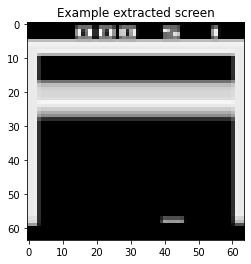

In [113]:
scaledScreenSize = (64,64)
grey = True
if grey:
    resize = T.Compose([T.ToPILImage(),
                        T.Resize(scaledScreenSize, interpolation=Image.CUBIC),
                        T.Grayscale(),
                        T.ToTensor()])
else:
    resize = T.Compose([T.ToPILImage(),
                        T.Resize(scaledScreenSize, interpolation=Image.CUBIC),
                        T.ToTensor()])

def get_screen(screen):

    finalScreen =[]
    for i in range(len(screen)):

        ## Need to convert data type to 32F
        tempScreen = np.ascontiguousarray(screen[i], dtype=np.float32) / 255
        tempScreen = torch.from_numpy(np.array(tempScreen)).permute(2,0,1)

        tempScreen = resize(tempScreen)

        finalScreen.append(tempScreen.unsqueeze(0))

    finalScreen = torch.cat(finalScreen).permute(1,0,2,3)

    return finalScreen.to(device)



temp = env.reset()
plt.figure()
if grey:
    plt.imshow(get_screen(temp).cpu().permute(1, 2,3, 0)[0].numpy(),
            interpolation='none', cmap='gray')
else:
    plt.imshow(get_screen(temp).cpu().permute(1, 2, 0).numpy(),
            interpolation='none')
plt.title('Example extracted screen')
plt.show()


In [114]:

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
video_every=10

# init with correct dims
init_screen = get_screen(env.reset())
print(init_screen.shape)
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters())

memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            x = policy_net(state)
            return x.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)



torch.Size([1, 4, 64, 64])


In [115]:

def optimize_model():

    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    tmp = target_net(non_final_next_states)

    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
video_every=5
# vid = gym.wrappers.monitoring.video_recorder.VideoRecorder(env, "./recordings/breakout/vid.mp4")
seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

marking=[]
episodeScores=[]
num_episodes = 1000
for n_episode in tqdm(range(num_episodes+1)):
    score=0
    # Initialize the environment and state
    temp = env.reset()
    state = get_screen(temp)

    for t in count():
        # Select and perform an action
        action = select_action(state)

        obvs, reward, done, info = env.step(action.item())

        score+=reward
        reward = torch.tensor([reward], device=device)

        # Observe new state
        next_state = get_screen(obvs)
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            break
    print(score, end='\r')
    episodeScores.append(score)
    # do not change lines 44-48 here, they are for marking the submission log
    marking.append(score)
    if n_episode%100 == 0:
        print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
            n_episode, score, np.array(marking).mean(), np.array(marking).std()))
        marking = []
    # Update the target network, copying all weights and biases in DQN
    if n_episode % TARGET_UPDATE == 0:

        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
# env.render()
env.close()


  7%|▋         | 66/1001 [14:44<4:42:18, 18.12s/it]

marking, episode: 0, score: 1.0, mean_score: 1.00, std_score: 0.00


In [ ]:
# Trend Graphs
m = max(episodeScores)
print([i for i, j in enumerate(episodeScores) if j == m])
plt.plot(range(num_episodes+1),episodeScores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.show()

In [ ]:
averages = []
tempAverage = 0
for i in enumerate(episodeScores):
    tempAverage+=i[1]
    if i[0]%10==0:
        averages.append(tempAverage/10)
        tempAverage=0
plt.plot(range(len(averages)),averages)
plt.ylabel('Average score')
plt.xlabel('per 10 episodes')
plt.show()

In [ ]:
averages = []
tempAverage = 0
for i in enumerate(episodeScores):
    tempAverage+=i[1]
    if i[0]%100==0:
        averages.append(tempAverage/100)
        tempAverage=0
plt.plot(range(len(averages)),averages)
plt.ylabel('Average score')
plt.xlabel('per 100 episodes')
plt.show()